# Lecture 3.3: Anomaly Detection

This lecture, we are going to use gaussian distributions to detect anomalies in our emoji faces dataset

**Learning goals:**

- Introduce an anomaly detection problem
- Implement Gaussian distribution anomaly detection for images
- Debug the optimisation of a learning algorithm
- Discuss the imperfection of learning algorithms
- Acknowledge other outlier detection methods


## 1. Introduction

We have an `emoji_faces` dataset of all our favourite emojis. However, Skynet hates their friendly expressiveness, and wants to destroy emojis forever! 🙀 It sent _terminator robots_ from the future to invade our dataset. We must act fast, and detect them amongst the emojis to prevent the catastrophy. 

Our challenge here, is that we don't watch many movies, so we don't have a clear idea of what those _terminators_ look like. 🤖 All we know, is that they look very different compared to emojis, and that only a handful managed to infiltrate our dataset.

This is a typical scenario of _anomaly detection_. We would like to identify rare examples that differ from our "normal" data points. We choose to use a Gaussian Distribution to model this "normality" and detect the killer robots.


## 2. Data Munging

First let's load the images using [pillow](https://pillow.readthedocs.io/en/stable/), like in lecture 2.2:

In [1]:
from PIL import Image
import glob

paths = glob.glob('emoji_faces/*.png')

images = [Image.open(path) for path in paths]
len(images)

134

We have 134 emoji faces, including a few terminator robots. We'll again be using the [sklearn](https://scikit-learn.org/) library to create our model. The interface is familiar: sklearn again expects a NumPy matrix where the rows are our images and the columns are the pixels. So we can apply the same transformations as notebook 3.2:

In [6]:
import numpy as np

arrays = [np.asarray(im) for im in images]
# 64 * 64 = 4096
vectors = [arr.reshape((4096,)) for arr in arrays]
data = np.stack(vectors)

In [7]:
data.shape

(134, 4096)

## 3. Training 

Next, we will create an [`EllipticEnvelope`](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html) object. This will fit a multi-variate gaussian distribution to our data. It then allows us to pick a threshold to define an _ellipsoid_ decision boundary, and detect outliers.

Remember that we are using a _learning_ algorithm, which must therefore be _trained_ before it can be used. This is why we'll use the `.fit()` method first, before calling `.predict()`:

In [12]:
from sklearn.covariance import EllipticEnvelope

#cov = EllipticEnvelope(random_state=0).fit(data)
# Too much dimension : 4096 => Hyperdimensionnal dataset more dimension that items 

😰 What's happening? Why is it stuck? Have the killer robots already taken over? 

No need to panic, this kind of hiccup is very common when dealing with machine learning algorithms. We can kill the process (before it fries our laptop fan) by clicking the `stop` button ⬛️ in the notebook toolbar.

Most learning algorithms are based around an _optimisation_ procedure. This step is often iterative and stochastic, i.e it tries its statistical best to maximise the learning in incremental steps. 

This process isn't fail proof:
* it can dramatically stop because of out of memory errors, or overflow errors 💥
* it can get stuck, e.g when the optimisation is too slow 🐌
* it can fail silently, and return wrong results 💩

ℹ️ We will encounter many of these failures throughout our ML experiments, so knowing how to overcome them is a part of the data scientist skillset. 

Let's go back to our killer robot detection: the model fitting got _stuck_ , which suggests that something about our data was too much to handle. We find the following "notes" in the [official documentation](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope):

> Outlier detection from covariance estimation may break or not perform well in high-dimensional settings.

We recall that our images are $64 \times 64$ pixels, so $4096$ dimensions.... that's a lot. It seems a good candidate to explain why our multivariate gaussian distribution failed to fit our dataset. If only there was a way to reduce the dimensions of our data... 😏

Let's apply PCA to reduce the number of dimensions of our dataset. Our emoji faces dataset is smaller than the full emoji dataset, so 40 dimensions should suffice to explain its variance: 


In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=40)
pca.fit(data)
components = pca.transform(data)
components.shape

(134, 40)

💪 Visualise the eigenvector images of our PCA model. You can use the code from lecture 3.2!

🧠 Can you explain what those eigenvector images represent? Why are they different than from the full emoji dataset?

Fantastic, we've managed to reduce the number of dimensions by 99%! Hopefully that should be enough to make our gaussian distribution fitting happy. Let's try again with the _principal components_ instead of the original data:

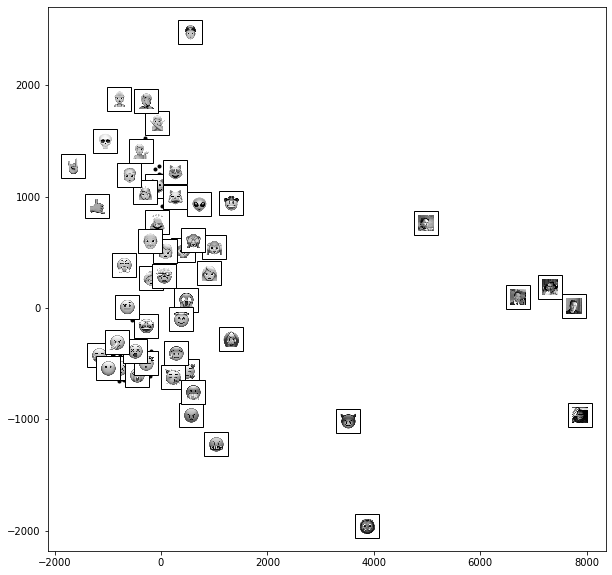

In [15]:
# Visualisation
from matplotlib import offsetbox
import matplotlib.pyplot as plt

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)
            
small_images = [im[::4, ::4] for im in arrays]
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(data,
                model=PCA(n_components=2),
                images=small_images, thumb_frac=0.02)

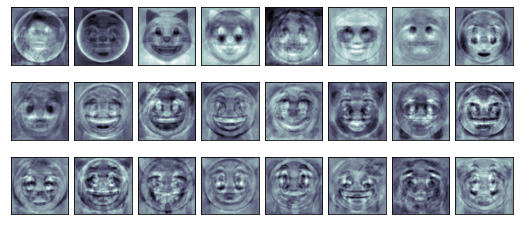

In [16]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(64, 64), cmap='bone')

In [11]:
cov = EllipticEnvelope(random_state=0).fit(components)

😅 that was fast!

## 4. Prediction

We can now use our fitted gaussian distribution to detect the outliers in our `data`. For this, we use the `.predict()` method:

In [17]:
y = cov.predict(components)
y

array([-1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1])

`y` is our vector of predictions, where $1$ is a normal data point, and $-1$ is an anomaly. We can therefore iterate through our original `arrays` to find outliers:

In [18]:
outliers = []

for image, prediction in zip(arrays, y):
    if prediction == -1:
        outliers.append(image)
len(outliers)

14

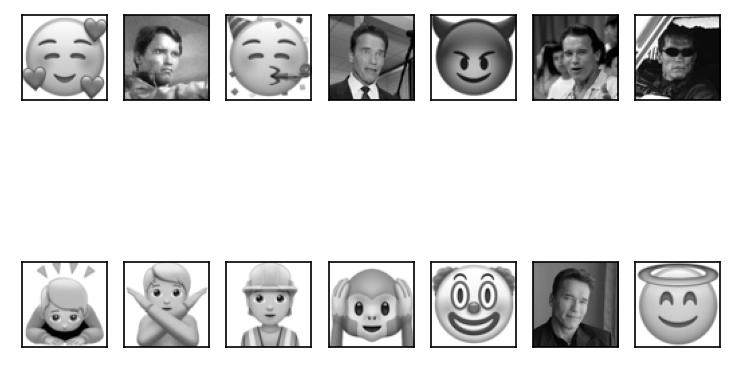

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(dpi=150, nrows=2, ncols=7)
for outlier, ax in zip(outliers, axs.flatten()):
    ax.imshow(outlier, cmap='gray', vmin=0, vmax=255)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

THERE'S OUR TERMINATORS! 🤖 We can count 5 of them in total. Notice how some real emoji faces were also detected as outliers. This is perhaps a sign that we should change our _threshold_ , to make the ellipsoid decision boundary smaller. 

In fact, we didn't even specify a threshold before, we just used the default value of `contamination=0.1` in the [`EllipticEnvelope`](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html) class. This represents our estimation of the proportion of data points which are outliers. Since it looks like we detected double the amount of actual anomalies, let's try again with `contamination=0.05`:

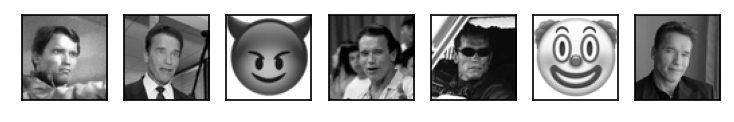

In [20]:
cov = EllipticEnvelope(random_state=0, contamination=0.05).fit(components)
y = cov.predict(components)

outliers = []

for i in range(0, len(arrays)):
    if y[i] == -1:
        outliers.append(arrays[i])
        
fig, axs = plt.subplots(dpi=150, nrows=1, ncols=7)
for outlier, ax in zip(outliers, axs.flatten()):
    ax.imshow(outlier, cmap='gray', vmin=0, vmax=255)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Better! `contamination=0.05` was a better choice of threshold, and we assessed this through _manual inspection_. This means we went through the results and used our human jugement to change the value of this _hyperparameter_.

ℹ️ Notice how our outlier detection is not _perfect_. Some emojis were also erroneously detected as anomalous killer robots. This can seem like a problem, or a sign that our model was malfunctioning. But, quite the contrary,  _imperfection_ is a core aspect of all _learning_ algorithms. Instead of seeing the glass half-empty and looking at the outlier detector's mistakes, we should reflect on the task itself. It would have been almost impossible to detect those killer robot images using rule-based algorithms, and our model _accuracy_ was good _enough_ to save the emojis from Skynet. As data scientists, our goal is to make models which are accurate _enough_ to be useful, not to aim for perfect scores. It is important to define usefulness and how it translates to measurable metrics before the start of a project.

## 5. Analysis

We have detected the robot intruders and saved the emojis from a jealous AI from the future, all is good! We still want to better understand how anomaly detection defeated Skynet. For this, we would like to leverage our shiny new data visualization skills. Representing our dataset in space would allow us to identify its structures and hopefully understand how our gaussian distribution model identified terminators as "abnormal".

Our data is high dimensional, so we can use our trusted PCA once again to project it down to 2 dimensions. We understand that this will lose a lot of the variance of our data, but the results were still somewhat interpretable with the full emoji dataset, so let's go!

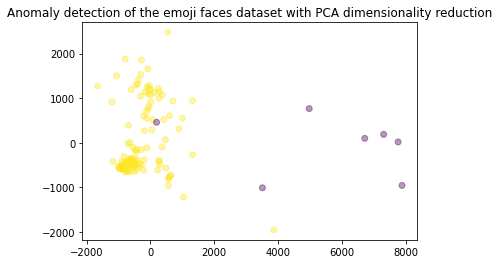

In [21]:
# Dimesionality reduction to 2
pca_model = PCA(n_components=2)
pca_model.fit(data) # fit the model
T = pca_model.transform(data) # transform the 'normalized model'

plt.scatter(T[:, 0], T[:, 1],
            # use the predictions as color
            c=y, 
            marker='o',
            alpha=0.4
        )
plt.title('Anomaly detection of the emoji faces dataset with PCA dimensionality reduction');

We can notice that most of the outliers are clearly _separable_ from the bulk of the dataset, even with only 2 principal components. One outlier is very much within the main cluster however. This could be explained by the dimensionality reduction, i.e that this point is separated from the cluster in other dimensions, or by the fact our threshold might be too permissive.

We can check this by displaying the images directly on the scatter plot:

In [22]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

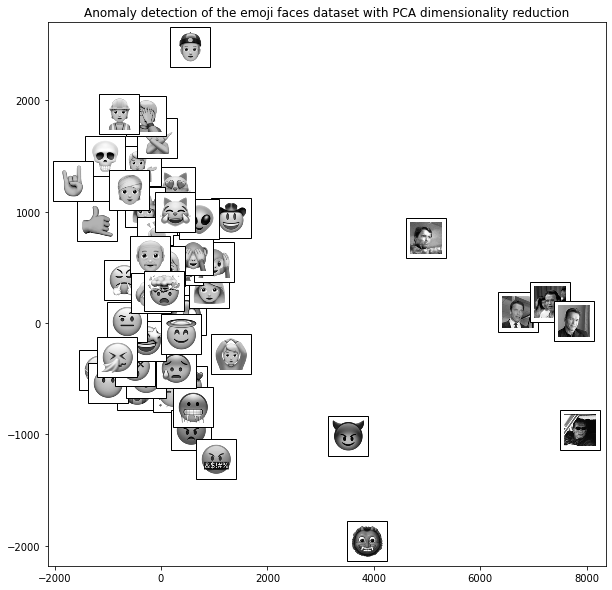

In [23]:
small_images = [im[::2, ::2] for im in arrays]
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(data,
                model=PCA(n_components=2),
                images=small_images, thumb_frac=0.02)
plt.title('Anomaly detection of the emoji faces dataset with PCA dimensionality reduction');

We could probably have reduced the value of `contamination` further, since we can see how the killer robots are clearly "abnormal" with this visualisation. We also have a "feel" of how our gaussian distribution model could successfully detect them as outliers. Although remember that all of modeling magic happens in 40 dimensional space!

🧠🧠 Can you explain why it is not very useful to display the ellipsoid decision boundary of our anomaly detection model on this graph?

## 6. More Anomaly Detection

Anomaly detection is an active field in ML research, which combines supervised, unsupervised, non-linear, Bayesian, ... a whole bunch of methods! Each solution will have its pros and cons, and developing a production level outlier detection system will require empirically evaluating and comparing them. For a breakdown of the methods available in sklearn, check out this excellent [blogpost](https://sdsawtelle.github.io/blog/output/week9-anomaly-andrew-ng-machine-learning-with-python.html), or the [official documentation](https://scikit-learn.org/stable/modules/outlier_detection.html). For an in-depth view of modern anomaly detection, watch this [video](https://youtu.be/LRqX5uO5StA). And for everything else, feel free to experiment with this dataset or any other. Good luck on finding all the killer robots!

## 7. Summary

Today, we defined **anomaly detection**, and listed some of its common applications including fraud detection and data cleaning. We then described how to use **fitted Gaussian distributions** to identify outliers. This lead us to a discussion about the choice of **thresholds** and **hyperparameters**, where we went over a few different realistic scenarios. We then used a Gaussian distribution to remove terminator images from an emoji faces dataset. We learned how learning algorithms **fail** and that data scientists must know how to **debug** them. Finally, we used **PCA** to visualize our killer robot detection. 


# Resources

## Core Resources

- [Anomaly detection algorithm](https://www.coursera.org/lecture/machine-learning/algorithm-C8IJp)  
Andrew Ng's limpid breakdown of anomaly detection

## Additional Resources

- [A review of ML techniques for anomaly detection](https://youtu.be/LRqX5uO5StA)  
More in depth review of modern techniques for anomaly detection
- [Anomaly Detection in sklearn](https://sdsawtelle.github.io/blog/output/week9-anomaly-andrew-ng-machine-learning-with-python.html)  
Visual blogpost experimenting with the various outlier detection algorithms available in sklearn
- [sklearn official documentation - outlier detection](https://scikit-learn.org/stable/modules/outlier_detection.html)  